<a href="https://colab.research.google.com/github/hariharanrl/DeepLearning/blob/master/Project_ATSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

##Mount Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Plotting function

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series,title, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Opening Stock Price")
    plt.grid(True)

## Loading the NSE-50 Dataset and plotting the series

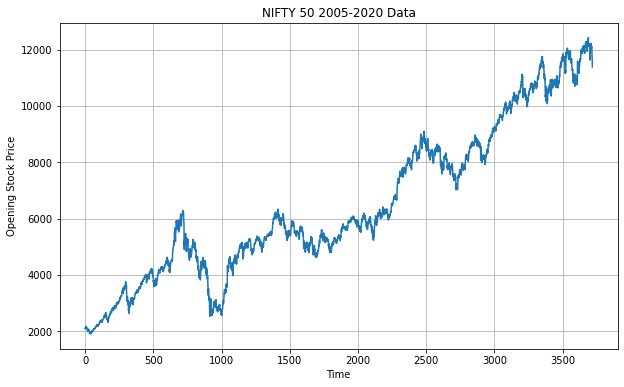

In [0]:
import csv
time_step = []
open_price= []
#close_price=[]

with open('/content/drive/My Drive/NITK/NSE.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    open_price.append(float(row[2]))
    #close_price.append(float(row[5]))
    time_step.append(int(row[0]))

series1= np.array(open_price)
#series2= np.array(close_price)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series1,title="NIFTY 50 2005-2020 Data")
#plot_series(time,series,start=1,end=300)
#plot_series(time,series2)

##Differencing the series to remove stationarity

(3717,)


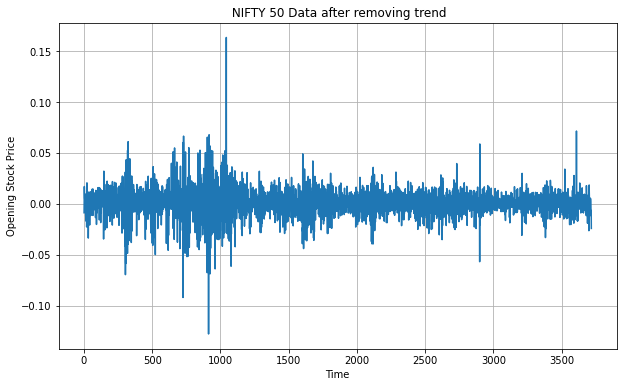

In [0]:
import pandas as pd
#series=[]
#for i in range(0,len(series1)):
#  value=series1[i]-series1[i-1]
#  series.append(value)
#len(series1)
#series=np.array(series)
logseries=pd.DataFrame((np.log(series1)))
#print(logseries)
series= logseries - logseries.shift()
series.dropna(inplace=True)
series=np.array(series)
series=series.reshape(3717,)
plt.figure(figsize=(10, 6))
time1=time[1:]
plot_series(time1,series,title=" NIFTY 50 Data after removing trend")
print(series.shape)

##Splitting the training and testing sets 

In [0]:
split_time = 3000
time_train = time1[:split_time]
x_train = series[:split_time]
time_valid = time1[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 3000


##Creating Windowed Dataset for training with LSTM Model

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

##Model Forecast

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

##Optimal Learning Rate

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 30
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
#
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0033 - mae: 0.0539 - lr: 1.0000e-07
Epoch 2/50
93/93 [==============================] - 1s 7ms/step - loss: 0.0012 - mae: 0.0254 - lr: 1.1220e-07
Epoch 3/50
93/93 [==============================] - 1s 7ms/step - loss: 7.5956e-04 - mae: 0.0211 - lr: 1.2589e-07
Epoch 4/50
93/93 [==============================] - 1s 7ms/step - loss: 6.1439e-04 - mae: 0.0196 - lr: 1.4125e-07
Epoch 5/50
93/93 [==============================] - 1s 7ms/step - loss: 5.3541e-04 - mae: 0.0188 - lr: 1.5849e-07
Epoch 6/50
93/93 [==============================] - 1s 7ms/step - loss: 4.8075e-04 - mae: 0.0181 - lr: 1.7783e-07
Epoch 7/50
93/93 [==============================] - 1s 7ms/step - loss: 4.4188e-04 - mae: 0.0177 - lr: 1.9953e-07
Epoch 8/50
93/93 [==============================] - 1s 7ms/step - loss: 4.1092e-04 - mae: 0.0173 - lr: 2.238

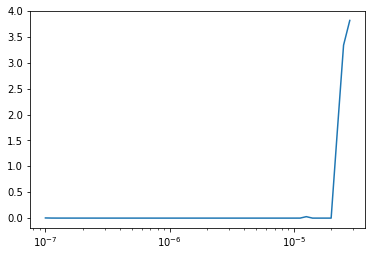

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-2, 0, ])

##Training the Model

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=30, batch_size=32, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 7ms/step - loss: 8.9222e-04 - mae: 0.0256
Epoch 2/100
93/93 [==============================] - 1s 7ms/step - loss: 4.3949e-04 - mae: 0.0171
Epoch 3/100
93/93 [==============================] - 1s 7ms/step - loss: 3.5613e-04 - mae: 0.0159
Epoch 4/100
93/93 [==============================] - 1s 7ms/step - loss: 3.1901e-04 - mae: 0.0154
Epoch 5/100
93/93 [==============================] - 1s 7ms/step - loss: 2.9761e-04 - mae: 0.0151
Epoch 6/100
93/93 [==============================] - 1s 7ms/step - loss: 2.8349e-04 - mae: 0.0149
Epoch 7/100
93/93 [==============================] - 1s 7ms/step - loss: 2.7284e-04 - mae: 0.0147
Epoch 8/100
93/93 [==============================] - 1s 7ms/step - loss: 2.6371e-04 - mae: 0.0145
Epoch 9/100
93/93 [==============================] - 1s 7ms/step - loss: 2.5696e-04 - mae: 0.0144
Epoch 10/100
93/93 [==============================] - 1s 7ms/step - loss: 2.5007e-04 - mae: 0.0142
Epoch 11/100
93/93 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

##Forecast Plot

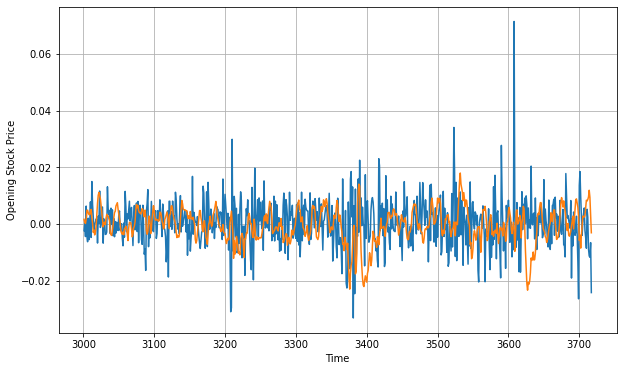

In [0]:
plt.figure(figsize=(10, 6))
#plot_series(time,series)
plot_series(time_valid, x_valid,title="Validated Data")
plot_series(time_valid, rnn_forecast,title="")

##Mean Absolute Error

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.007860926

##Loss Curves

<Figure size 432x288 with 0 Axes>

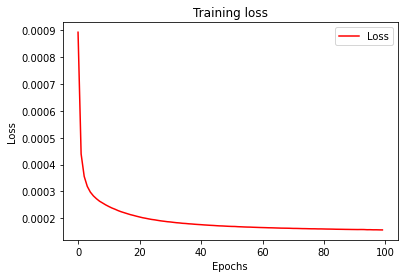

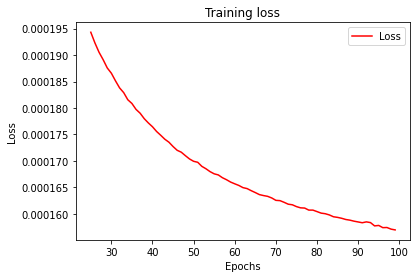

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[25:]
zoomed_epochs = range(25,100)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

##Forecast


In [0]:
print(np.exp(rnn_forecast))

[1.0016152  1.0006145  1.0001501  1.0017295  1.0047491  1.0048823
 1.0037959  1.0032892  1.0033504  1.0044372  1.0051261  1.0020959
 1.0001659  0.99701136 0.99779385 0.9961257  0.9971702  0.99924845
 1.0033206  1.0073333  1.0101752  1.0111547  1.010125   1.0089712
 1.0066829  1.0042384  1.001536   0.9989648  1.0001899  1.000599
 0.99971366 1.0020436  1.0033432  1.002946   1.0028     1.0018716
 1.0011159  0.9969386  0.99618554 0.99594206 0.99793273 0.9995198
 1.0022049  1.0040317  1.0044656  1.0063503  1.0069599  1.0075147
 1.0052538  1.0034101  1.001443   1.0000119  0.9975114  0.9967301
 0.99636203 0.99714786 0.99621993 0.9982991  0.9985766  0.9991895
 0.9981561  0.99642926 0.99413556 0.998571   1.0005522  1.0005375
 1.000401   0.9982926  0.9954578  0.9962257  0.99856395 0.99923927
 1.0008638  1.0047117  1.0068995  1.0057138  1.0065353  1.0047665
 1.0039932  1.0039837  1.0035001  1.0044532  1.005409   1.0050069
 1.0033745  1.0025132  1.004888   1.0027015  0.9975989  0.99636626
 0.99716

In [0]:
print(len(rnn_forecast))

717


##Don't need to run this 

In [0]:
logseries1=logseries[3000:]
pred_log=pd.Series(logseries1.iloc[0] ,index=logseries1.index)
rnn_forecast_sum=rnn_forecast.cumsum()
pred_log=pred_log.add(rnn_forecast_sum,fill_value=0)
pred_rnn=np.exp(pred_log)
print(pred_rnn)
#plot_series(time_valid,x_valid)
#plot_series(time_valid,pred_rnn)

3001    1.001615
3002    1.002231
3003    1.002381
3004    1.004115
3005    1.008883
          ...   
3713    0.655897
3714    0.663735
3715    0.669970
3716    0.671998
3717    0.669903
Length: 717, dtype: float64
